In [1]:
# Setting up

# Import required modules
import glob
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import sklearn

# Store the path of the folder containing the data
# Alternatively, could use user input - 
# path = input('Enter the file path of the data: ')
path = '/Users/AV/Dropbox/COBRE/cfgData/'

# Need to alphabetise and store the filenames in the path
Orig_TS_path_names = sorted(glob.glob(path + '*.mat'))
TS_path_names = sorted(glob.glob(path + '*.mat'))
print(len(Orig_TS_path_names))

145


In [2]:
# Import and store the fd averages
# Define a function that modifies the entries within TS_path_names based on the threshold fd value

def removePathNames(threshold_fd, TS_path_names):
    
    filePath = '/Users/AV/Dropbox/COBRE/movementData/fdAvgs_COBRE.txt'
    fdAvgs = pd.read_csv(filePath,header=None);

    indices2Del = np.where(fdAvgs > threshold_fd)[0]
    indices2Keep = np.where(fdAvgs <= threshold_fd)[0]
    
    for i in sorted(indices2Del, reverse=True):
        del TS_path_names[i]
    return TS_path_names, indices2Keep

TS_path_names, indices2Keep = removePathNames(0.30, TS_path_names)
indices2Keep = indices2Keep.tolist()
print(indices2Keep)

[0, 2, 3, 4, 6, 8, 10, 13, 14, 17, 18, 19, 20, 21, 22, 23, 27, 28, 29, 32, 33, 35, 36, 37, 43, 45, 47, 48, 50, 51, 52, 53, 55, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 73, 75, 76, 78, 82, 84, 87, 88, 89, 90, 95, 99, 100, 101, 103, 105, 106, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 142, 143, 144]


In [3]:
# Reading in the feature matrix data from the .txt file

# Import and store the feature matrix in the variable tsData
filePath = '/Users/AV/Desktop/FeatureMatrixData/element1_COBRE.txt'
tsData = pd.read_csv(filePath,header=None);

In [4]:
# Creating the target column

filePath = '/Users/AV/Dropbox/COBRE/participants.csv'
COBRE = pd.read_csv(filePath,header=None);

targetCol = COBRE.iloc[1:,2]
targetCol = targetCol.tolist()
targetCol = pd.DataFrame(data=targetCol, columns=['target'])
targetCol = targetCol.iloc[indices2Keep,:]
targetCol = np.asarray(targetCol,dtype=np.int)

In [5]:
# Creating the target column

# This function, when called, prompts the user to input a string
# which can be used to uniquely identify any SCZ data file
# It returns a binary target column (0 = control, 1 = SCZ)

# def getTargetCol(TS_path_names):
    
#     # string = input('Enter a string found in all filenames that only contain SCZ data: ')
#     string = '-5'
#     # In this case '-5' should do
    
#     # Initialise and format a target column of length TS_path_names
#     x = np.zeros(len(TS_path_names))
#     x = x.astype(int)
#     Diagnosis = np.reshape(x,(len(TS_path_names),1))

#     # Initialise an index
#     i = 0

#     for path in TS_path_names:
#         if string in path:
#             # If the string is found, the data must be from a SCZ patient
#             Diagnosis[i] = 1
#             # Increment index
#             i += 1
#         else:
#             # Increment index
#             i += 1
#     return Diagnosis

# targetCol = getTargetCol(TS_path_names)

Control = (targetCol == 1).sum()
print('Control = ' + str(Control))
SCZ = (targetCol == 2).sum()
print('SCZ = ' + str(SCZ))
Total = SCZ + Control

Control = 56
SCZ = 34


In [6]:
# ROI selection

# This function takes a ROI as an input and gets the relevant slice (or rows) from tsData

def getROISlice(Orig_TS_path_names, tsData, ROI):
    
#     ROI = input('Which ROI is being analysed?: ')
    
    # Initialise a boolean
    validROI = False
    
    while validROI == False:
    
        # Rows per region of interest = len(TS_path_names)
        rowsPerROI = len(Orig_TS_path_names)
        [rows,cols] = tsData.shape

        # Get the rows corresponding to the mth region of interest, specified by the variable, indices2Keep
        ROISlice = tsData.iloc[((int(ROI)-1)*rowsPerROI):(int(ROI)*rowsPerROI),:]
        ROISlice = ROISlice.iloc[indices2Keep,:]

        # Assigning min and max values for input 'm'
        minROI = 1
        maxROI = int(rows/rowsPerROI)

        if minROI <= int(ROI) <= maxROI:
            validROI == True
            return ROISlice, ROI, maxROI
#         else:
#             print('Error: Please select a ROI between ' + str(minROI) + ' and ' + str(maxROI))
#             print('')
#             ROI = input('Which ROI is being analysed?: ')
            
# Need to z-score the selection of tsData
from scipy.stats import zscore
ROISlice, ROI, maxROI = getROISlice(Orig_TS_path_names, tsData,29)

# Assign the data to variables
y = np.ravel(targetCol)

In [7]:
# Need to store the data as a 3D feature matrix which will allow access to relevant slices
# [rows,cols,layers] = i, j, k = 185, 22, ROIs - varies element to element

featMat3D = np.zeros((len(TS_path_names),22,maxROI))

# Loop through each slice and store it in the matrix
for i in range(1, maxROI+1):
    featMat3D[:,:,i-1] = getROISlice(Orig_TS_path_names, tsData,i)[0]

def getFeatSlice(featMat3D, feature):
    if 0 < feature <= 22:
        FeatSlice = featMat3D[:,feature-1,:]
        return FeatSlice

FeatSlice = pd.DataFrame(getFeatSlice(featMat3D,3))

DataSlice = ROISlice # FeatSlice # or ROISlice
DataSlice_zscored = DataSlice.apply(zscore)
X = DataSlice_zscored

In [8]:
# Perform 10-Fold Cross Validation

# This function...

def get10FoldCVScore(X,y):
    
    # Import the support vector classifier and balance the classes
    from sklearn.svm import SVC
    svclassifier = SVC(kernel='linear') # , class_weight = {0:(SCZ/Total),1:(Control/Total)})

    # Split the data into training and test sets
    from sklearn.model_selection import StratifiedKFold
    n = 10
    skf = StratifiedKFold(n_splits=n)
    
    # Import accuracy score
    from sklearn.metrics import balanced_accuracy_score
    
    # Initialise a few variables
    scores = np.zeros(n)
    i = 0
    
    for train_index, test_index in skf.split(X,y):
        
        train_index = train_index.tolist()
        test_index = test_index.tolist()
        
        print("Train:", train_index)
        print('')
        print("Validation:",test_index)
        
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:] 
        y_train, y_test = y[train_index], y[test_index]
        
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict(X_test)
        
        print('')
        print('y_test = ', y_test)
        print('')
        print('y_pred = ', y_pred)
        print('')
        
        scores[i] = '{0:.1f}'.format(balanced_accuracy_score(y_test, y_pred)*100)
        print('Acc % = ', scores[i])
        print('')
        
        # Increment index
        i += 1  
    return scores

# Store the function's output as a variable
scores = get10FoldCVScore(X,y)

# Print scores
print('10-fold CV scores as a percentage: ' + str(scores))
print('')

# Mean 10-fold CV score with an error of 1 std dev
print("Accuracy as a percentage: %0.1f (+/- %0.1f)" % (scores.mean(), scores.std()))

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 1 1 2 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 2 1 1 1 1 2 1 1]

Acc % =  79.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33

In [9]:
# Plot SVM feature weights

# colors = ['r']*22

# from sklearn.svm import SVC
# svclassifier = SVC(kernel='linear')

# imp = svclassifier.fit(X,y).coef_.ravel()
# blue = np.where(imp > 0)

# i = 0

# for c in imp:
#     if c > 0:
#         colors[blue[0][i]] = 'b'
#         i += 1

# colors = np.array(colors).reshape(22,1)
# df3 = pd.DataFrame(data=colors)

# names = ['CO_Embed2_Dist_tau_d_expfit_meandiff', 'CO_FirstMin_ac', 'CO_HistogramAMI_even_2_5', 'CO_f1ecac', 'CO_trev_1_num',
#              'DN_HistogramMode_10', 'DN_HistogramMode_5', 'DN_OutlierInclude_n_001_mdrmd', 'DN_OutlierInclude_p_001_mdrmd',
#              'FC_LocalSimple_mean1_tauresrat', 'FC_LocalSimple_mean3_stderr', 'IN_AutoMutualInfoStats_40_gaussian_fmmi',
#              'MD_hrv_classic_pnn40', 'PeriodicityWang_th0_01', 'SB_BinaryStats_diff_longstretch0',
#              'SB_BinaryStats_mean_longstretch1', 'SB_MotifThree_quantile_hh', 'SB_TransitionMatrix_3ac_sumdiagcov',
#              'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
#              'SP_Summaries_welch_rect_area_5_1', 'SP_Summaries_welch_rect_centroid']
# names = np.array(names).reshape(22,1)

# df1 = pd.DataFrame(data=names)
# df2 = pd.DataFrame(data=imp)
# df = pd.concat([df1, df2, df3], axis = 1)
# df.columns = ["feat_names", "feat_imp", "colors"]
# df_sorted = df.sort_values(by=['feat_imp'])

# print(df_sorted)

# colors = df_sorted.iloc[:,2].tolist()

# ax = df_sorted.plot.bar(x='feat_names', y='feat_imp', color=colors, legend=False)
# ax.set_xlabel("Feature Names")
# ax.set_ylabel("Feature Weights")
# plt.show()

# 1.	CO_Embed2_Dist_tau_d_expfit_meandiff
# 2.	CO_FirstMin_ac
# 3.	CO_HistogramAMI_even_2_5
# 4.	CO_f1ecac
# 5.	CO_trev_1_num
# 6.	DN_HistogramMode_10
# 7.	DN_HistogramMode_5
# 8.	DN_OutlierInclude_n_001_mdrmd
# 9.	DN_OutlierInclude_p_001_mdrmd
# 10.	FC_LocalSimple_mean1_tauresrat
# 11.	FC_LocalSimple_mean3_stderr
# 12.	IN_AutoMutualInfoStats_40_gaussian_fmmi
# 13.	MD_hrv_classic_pnn40
# 14.	PeriodicityWang_th0_01
# 15.	SB_BinaryStats_diff_longstretch0
# 16.	SB_BinaryStats_mean_longstretch1
# 17.	SB_MotifThree_quantile_hh
# 18.	SB_TransitionMatrix_3ac_sumdiagcov
# 19.	SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1
# 20.	SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1
# 21.	SP_Summaries_welch_rect_area_5_1
# 22.	SP_Summaries_welch_rect_centroid

In [10]:
# Compute the t-values (from a two-tail t-test) and the p-values
# Store these two values (t-value, then p-value) in each row, 22 in total for each feature

# This function...

def getTPVals(targetCol, DataSlice):
    
    from scipy.stats import stats,ttest_ind

    # Initialise the array and assign its shape
    tpValArray = np.zeros([22, 2])
    [rows, cols] = tpValArray.shape

    # Make a custom range of rows which can be used to distinguish the control data from the SCZ data
    # Find all instances of 0 in the target column (which would indicate control data)
    # and store the indices in an array
    a = np.where(targetCol == 1)[0]
    aStart = a[0]
    aEnd = a[-1] + 1

    # Find all instances of 1 in the target column (which would indicate SCZ data)
    # and store the indices in an array
    b = np.where(targetCol == 2)[0]
    bStart = b[0]
    bEnd = b[-1] + 1

    DataSlice = pd.DataFrame(data=DataSlice)

    # Loop through the array and store the t and p values
    for i in range(rows):

        # Calculate the t and p values by inputting the two halves of each of the 22 columns
        # of the normalised data into the ttest functions
        # Store the statistics in the variable, tpVal (which changes on each iteration of the outer loop)
        controlFeatCol = DataSlice.iloc[aStart:aEnd,i]
        SCZFeatCol = DataSlice.iloc[bStart:bEnd,i]
        tpVal = stats.ttest_ind(controlFeatCol, SCZFeatCol)

        for j in range(cols):

            # Store the values into each column
            tpValArray[i,j] = tpVal[j]

    # Since it is a two-tailed t-test, need to multiply the p-values by two (second column)
    tpValArray[:,1] = tpValArray[:,1] * 2

    # Formatting the tpValArray
    tpValDf = pd.DataFrame(data=tpValArray, columns=['t-value', 'p-value'])
    tpValDf.index.name = 'Feature i'

    # Sort the data (including the indices) in descending order by MAGNITUDE
    tpValDf_sorted = tpValDf.abs().sort_values(by='t-value',ascending=False)

    # Store the first five indices of the sorted dataframe - will need to use these
    # indices to access the relevant feature columns in X, the feature matrix
    indexVals = tpValDf_sorted.index.values
    signifTVals = indexVals[:5]

    return tpValDf, tpValDf_sorted, signifTVals

# Store the function's outputs
tpValDf, tpValDf_sorted, signifTVals = getTPVals(targetCol, DataSlice)

# print(tpValDf)
# print('')
# print(tpValDf_sorted)
# print('')
# print(signifTVals)
# print('')

         PC1       PC2  target
0  -3.516580 -1.029304       2
1  -1.133616  0.881873       2
2  -3.362711  0.878083       2
3  -0.721129  2.066510       2
4  -0.010294 -2.374846       2
5  -3.803163 -0.184140       2
6  -2.787733 -0.080022       2
7  -6.794599 -0.148248       1
8   6.961982 -0.133364       1
9  -0.267987  0.258343       1
10 -0.771355 -0.007446       1
11  0.649276  2.003020       1
12  0.043621  1.350360       1
13 -1.631193  0.535898       2
14  1.132470 -2.036083       2
15 -0.714153  1.735476       1
16  1.091988 -0.524036       1
17 -1.261912  0.235868       2
18 -1.817125 -0.218885       2
19 -1.228581 -2.150774       2
20  0.717669  0.840390       1
21 -1.856170 -1.639415       1
22 -1.905791  0.825966       1
23  0.452115 -0.049527       2
24  3.143974 -1.098788       1
25  2.565016 -1.269953       1
26 -2.605659  0.349486       2
27  5.706297  1.252802       1
28 -0.207422  0.221872       1
29 -1.668294 -0.478439       1
..       ...       ...     ...
60  3.45

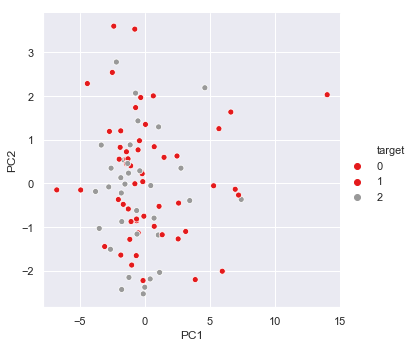

In [11]:
# PCA

# This function...

def showMePCAFig(DataSlice, targetCol):
    
    from sklearn.preprocessing import StandardScaler

    # Standardizing the features
    x = StandardScaler().fit_transform(DataSlice)

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents
                 , columns=['PC1', 'PC2'])

    targetCol_df = pd.DataFrame(data=targetCol, columns=['target'])

    finalDf = pd.concat([principalDf, targetCol_df], axis = 1)

    print(finalDf)

    # Plotting the PCA scatterplot using Seaborn
    sns.set()
    ax = sns.relplot(x='PC1', y='PC2', data=finalDf, hue='target',palette='Set1')
    plt.show()
    return

showMePCAFig(DataSlice, targetCol)

In [12]:
# Violin plots

# This function...

# boolean == 0: when looking at FeatSlices
# boolean == 1: when looking at ROISlices

def showMeViolinPlts(targetCol, signifTVals, DataSlice):
    
    boolean = int(input('Is DataSlice = FeatSlice or ROISlice? Enter 0 or 1 respectively: '))
    number = input('Which Feature / ROI is being analysed?: ')
    
    # Create an index for the subplot
    n = 1;
    
    fig = plt.figure()

    # Copy pasted (code enables custom selection of rows)
    a = np.where(targetCol == 1)[0]
    aStart = a[0]
    aEnd = a[-1] + 1

    b = np.where(targetCol == 2)[0]
    bStart = b[0]
    bEnd = b[-1] + 1
    
    DataSlice = pd.DataFrame(data=DataSlice)
    
    # Z-score the data
    DataSlice = DataSlice.apply(zscore)
    
    for i in signifTVals:
        # Obtain control feature i and SCZ feature i (all the rows)
        # from the ith column of the z-scored feature matrix
        cf_i = DataSlice.iloc[aStart:aEnd,i]
        sf_i = DataSlice.iloc[bStart:bEnd,i]

        # Convert into a dataframe
        df_feat_i = pd.DataFrame({'SCZ':sf_i,'Control':cf_i})

        # Violin plots
        ax = fig.add_subplot(2,3,n)
        ax = sns.violinplot(data=df_feat_i, order=['SCZ','Control'])
        plt.xlabel('Diagnosis')
        
        if boolean == 0:
            ylabel = 'ROI ' + str(i)
        elif boolean == 1:
            ylabel = 'Feature ' + str(i)
        plt.ylabel(ylabel)
        
        # Increment index
        n += 1;
        
    if boolean == 0:
         plt.suptitle('Top 5 ROI in Feature ' + str(number), fontsize=12.5, y=1.05)   
    elif boolean == 1:
        plt.suptitle('Top 5 Features in ROI ' + str(number), fontsize=12.5, y=1.05)
    plt.tight_layout()
    plt.show()
    return

# showMeViolinPlts(targetCol, signifTVals, DataSlice)

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 2 2 1 1 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 2 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 2 2 1 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 2 1 1 2 2]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 2 2 1 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 1 1 2 1 1 2]

Acc % =  46.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 2 2 2 2 2]

Acc % =  20.8

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 1 2 2 1]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 1 1 2 2]

Acc % =  30.0

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 2 1 1 2 1 2]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 2 1 2 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 2 1 2 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 2 2 1 2 2 1 1]

Acc % =  80.0

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 2 1 1 1 1 2 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 1 2 1 1 1 1]

Acc % =  30.0

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 2 2 2 1 1 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 2 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 2 1 2 2 2]

Acc % =  26.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 2 1 2 2 2 1]

Acc % =  80.0

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 2 2 2 2]

Acc % =  63.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 2 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 1 1 2 1 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 2 1 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 2 1 1 2 1 1 1]

Acc % =  73.3

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 1 1 1 1 2 1 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 2 2 1 1 1 2 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 1 2 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 2 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 2 1 1 1 2]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 2 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 2 1 1 1 2]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 1 2 2 1]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 2 1 2 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 2 2 1 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 2 1 1 1 1]

Acc % =  40.0

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 1 1 1 2 2 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 2 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 2 1]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 1 2 1 1 2]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [4, 5, 6, 13, 14, 15, 16, 1

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 2 1 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1 2 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23,


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 2 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 2 1 1 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 1 1 1 2 1 1]

Acc % =  83.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 2 2 1 2]

Acc % =  37.5

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 2 1 1 2 2 2 1]

Acc % =  29.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 2 1 1 2 2 2]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 2 1 1 1 1 1]

Acc % =  100.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 2 1 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 2 1 1 1 1 2]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 2 1 2 2 2 2]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 1 2 1 1 1 2 1]

Acc % =  75.0

Train: [0, 1, 2, 3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 1 2 1 1 1 2]

Acc % =  16.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 2 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 1 2 1 1 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 2 1]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 2 2 1 2 1 1 1]

Acc % =  29.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 1 1 2 2 2 1]

Acc % =  91.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 1 1 1 1 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 2 1 2 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 1 1 2 2 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 2 1 1 2 1 2]

Acc % =  37.5

Train: [0,


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 1 1 1 2 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 2 1 2 1 2 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 2 1 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 2]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 2 2 2 1]

Acc % =  10.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 1 2 1 2 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 1 1 1 1 1 2]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 2 2 2 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 1 1 1 2 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 1 2 1 1 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 1 2 1 1 2 1]

Acc % =  16.7

Train: [0, 1, 2, 3


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 2 2 2]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 2 1 1 2 2]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 1 2 1 1 1 1]

Acc % =  30.0

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1 2 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 2 1 1 2]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 2 1 1 1 1 1 2]

Acc % =  66.7

Train: [0,


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 1 2 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 2 1 1 1 2 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 2 1 2 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3

Acc % =  50.0

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 2 1 2 2 1 2 2]

Acc % =  54.2

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 2 1 1 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23,

Acc % =  54.2

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 1 1 2 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1 2 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 1 1 1 1 1 2]

Acc % =  66.7

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 2 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 2 1 1 1 1 1]

Acc % =  66.7

Train: [0,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 1 1 2 1 2]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 2 2 1 2 1]

Acc % =  36.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 2 2 1 1 1 2 1]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 1 1 1 2 1 2]

Acc % =  73.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 2 1 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 2 1 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 1 1 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 2 1 1 2 1]

Acc % =  45.8

Train: [0,


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 2 2 1 1 1 1 2]

Acc % =  16.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 1 2 2 1 2 1 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 2 2 1 1 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 2 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  66.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 2 1 1 1 1 2]

Acc % =  45.8

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 1 1 1 2 1 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 2 2 1 1]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 2 1 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 2 1 2 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 2 1 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 2 1 1 1 1 2 1]

Acc % =  79.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 2 1 1 2 2 1 2 2]

Acc % =  54.2

Train: [0,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 2 2 1 1 1 2 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 1 2 1 1 1 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 1 1 2 2 2]

Acc % =  75.0

Train: [0, 1, 


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 1 1 2 2 2 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 1 1 1 1 2 1 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 2 2 2 2 2 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 1 2 2 1 1 2]

Acc % =  50.0

Train: [0, 1, 2, 3

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 1 1 2 1 2 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 2 2 1]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 1 2 2 2 2 2]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 2 2 2 2 1 2]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 1 1 2 2 1 1]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 2 1 1 1 2 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 1 2 1 1 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 2 1 1 1 1 1]

Acc % =  30.0

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 2 1 2]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 1 2 1 1 2 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 1 1 1 1 1 1 1 1]

Acc % =  62.5

Train: [0,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 1 2 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 2 1 1 2 1 2 2]

Acc % =  29.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 1 1 1 2 1 1 1]

Acc % =  58.3

Train: [0, 1, 


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 1 2 1 1 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 1 1 1 2 2 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1 1 2]

Acc % =  54.2

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 2 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 1 1 1 2]

Acc % =  66.7

Train: [0,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 2 1 1 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 1 1 1 1 2 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 2 1 2 1 1 1 1]

Acc % =  25.0

Train: [0, 1, 


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 1 2 1 2 1 2]

Acc % =  8.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 2]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 1 2 1 1 1 2 2]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 1 1 2 2 1 1 2]

Acc % =  41.7

Train: [0, 1, 


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 2 1 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 1 1 1 2]

Acc % =  40.0

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 1 1 2 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 2 1 1 1 2 2]

Acc % =  80.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 2 2 1 1 2]

Acc % =  37.5

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 2 2 2 2 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 2 1 1 1 1 2 2]

Acc % =  70.8

Train: [0,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 2 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 2 2 2]

Acc % =  16.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 2 1 1 2 1]

Acc % =  58.3

Train: [0,

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 2 1 1 2 1 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 2 2 2 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 2 1 1 1 1 2]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 2 1 2 1 1]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 2 1 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 2 2 1 1 1]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 2 1 1 1 1 2]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 2 1 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 1 1 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 2 1 2 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 2 1 2 2 1]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 2 1 1 1 1]

Acc % =  30.0

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 2 2 1 1 1 2 1]

Acc % =  70.8

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 2 2 2]

Acc % =  16.7

Train: [0, 1, 2, 3


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 1 2 2 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 2 2 1 2 1]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 2 1 1 2 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 1 1 2 1 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 1 1 1 1 1 2 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 2 2 1 1 1 2]

Acc % =  80.0

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 1 1 2 1 1]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 1 1 2 1 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 2 2 2 1 1 1 1]

Acc % =  70.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 2 1 1 2 1]

Acc % =  54.2

Train: [0,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 1 1 2 1]

Acc % =  40.0

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1 2 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 2 1 1 1 2 1 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 1 2 1 1 2 1 1]

Acc % =  50.0

Train: [0, 1, 


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 1 1 1 2 1 1]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 2 1 1 1 2 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 1 1 1 2]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 1 2 2 1 1]

Acc % =  73.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1 2 2]

Acc % =  45.8

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 2 1 1 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 2 1 1 2 2 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 1 1 2 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 1 1 2 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 2 1 1 1 1 2]

Acc % =  50.0

Train: [0, 1, 2, 3


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 2 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 1 1 2 1 2]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 2 2 1 1 1 1 1]

Acc % =  46.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 2 2 1 1 2 2]

Acc % =  29.2

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 2 1 2 1 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 1 2 2]

Acc % =  25.0

Train: [0,


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 2 1 1 2 1 2 1]

Acc % =  16.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 2 1 1 1 1 1 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 1 2 1 2 2 2]

Acc % =  25.0

Train: [0, 1, 2, 3


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 2 2 2 1 2 2 1]

Acc % =  43.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 2 2 1 2]

Acc % =  73.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 2 2 1 1 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 2 1 1 2 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 2 1 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 2 1 2 2 2 1 1 1 1]

Acc % =  70.8

Train: [0,


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 1 2 1 1 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 2 1 1 1 2 2]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 

Acc % =  46.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 1 2 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1 1 2]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 2 1 1 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 2 1 2 1 2 1 2]

Acc % =  50.0

Train: [0,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 1 1 2 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 2 2 1 1 1 1]

Acc % =  25.0

Train: [0, 1, 


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 2 1 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 2 1 1 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 2 1 1 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 1 1 1 2 2 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 1 1 2 2 1 2 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 1 1 1 1 2 1]

Acc % =  25.0

Train: [0, 1, 2, 3


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 2 2 2 2 1 1 2]

Acc % =  43.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 2 1 1 2 2 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1 1 2]

Acc % =  33.3

Train: [0, 1, 2, 3

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 1 1 2 2 1 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 1 1 1 2 2 2]

Acc % =  63.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1 2 2]

Acc % =  45.8

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 1 1 2 1 2 2]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 1 2 2 1]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 1 2]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 2 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 1 2 1 2 2 1]

Acc % =  53.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 2]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 1 2 1 1 1 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 2 1 1 1 1 1 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 1 2 2 2 1 1 2]

Acc % =  83.3

Train: [0, 1, 2, 3


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 2 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 2 1 1 2 1]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 1 1 1 1 1]

Acc % =  40.0

Train: [4, 5, 6, 13, 14, 15, 16, 1

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 1 2 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 1 1 1 2 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 1 1 2 1 1 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 1 1 1 1 1 1]

Acc % =  62.5

Train: [0,


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 2 1 1 1 1 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 2 1 1 1 1 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 1 2]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 2 1 1 1 1 2 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 2 2 1 2 2 2]

Acc % =  20.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 2 2 1 1 2 1]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 2 2 1 1 2]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 2 1 2 2]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 2 1 2 2 1]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 1 1 1 2]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 1 2 2 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 2 2 2 2 1 1 2 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 2 1 1 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 1 2 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 2 1 1 1 2 1 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred 


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 2 1 1 2 1 2 2]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 1 1 2 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 2 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 1 1 2 1 1 2]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 1 1 2 2 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 2 1 2 1 2 1]

Acc % =  58.3

Train: [0, 1, 2, 3


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 2 1 1 2 2 1 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 1 1 2 2 1 2 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 2 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 2 2 2 2 1]

Acc % =  43.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 2 2 2 1 1 1 2]

Acc % =  26.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 2 2 1]

Acc % =  25.0

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 1 1 2 1 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 2 2 2 1 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 2 1 2 1 2 1]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 2 2 2 1 1 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 1 1 1 2 1 1 2 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 1 1 1 1 2 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 2 1 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 2 1 1 1 2 1 1 2 1]

Acc % =  79.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 2 1 2 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 2 1 1 2 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 2 1 2 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 2 1 1 2 1 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 2 1 1 1 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 2 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 2 1 2 1 1 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 2 1 2 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 1 2 2 1 2 1 1]

Acc % =  37.5

Train: [0,

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 1 1 2 1 1 1]

Acc % =  83.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1 2 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 1 2 1 1 1 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 1 1 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 1 1 1 2 2 2]

Acc % =  25.0

Train: [0, 1, 2, 3


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 2 1 1 2 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 1 1 1 2 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 2 1 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 7, 8, 

Acc % =  58.3

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 2 2 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 2 1 1 2 2]

Acc % =  16.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 2 1 2 1 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 2 1 1 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 1 2 2 2 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 1 1 2 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 2 2 1 1 1]

Acc % =  45.8

Train: [0,


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 2 1 1 2 2 2 1]

Acc % =  16.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 1 1 1 2 1 2 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 1 2 2 1 2 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 2 2 2 1 2]

Acc % =  53.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 1 2 2 1 1]

Acc % =  73.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 2 1 1 1 2 1 2]

Acc % =  70.8

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 1 1 1 2]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0,


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 2 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1 2 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 2 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 2 1 2 2 1 2 1]

Acc % =  50.0

Train: [0,


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 1 2 2 1 1 1 1 2]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 2 2 1 1 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 2 1 1 1 1 2]

Acc % =  90.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 2 2 1 1 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 1 2 2 1]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 2 1 1 2 1 2]

Acc % =  50.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 1 1 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 1 1 1 1 1 2 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 2 2 1 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 2 1 2 1 2 1 2]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 2 1 1 1 1 2]

Acc % =  66.7

Train: [0,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 2 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 2 1 1 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 2 2 2 2 1 1]

Acc % =  29.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 2 1 1 1 1 1 1]

Acc % =  87.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 2 1 1 2 2 1 2]

Acc % =  29.2

Train: [0,


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 1 2 2 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 2 2 1 1 1 2 2]

Acc % =  50.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 1 2 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 1 2 2 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 1 1 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 2 1 1 1 1 2 2]

Acc % =  58.3

Train: [0,


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 2 1 2 1 1 1]

Acc % =  73.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 2 1 1 2 1 2 1]

Acc % =  70.8

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 2 1 1 2 2]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 2]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 2 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 1 1 1 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 1 1 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 1 2 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 1 2 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 1 1 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 1 2 2 1 1 2]

Acc % =  58.3

Train: [0, 1, 2, 3


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1 2 2]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1 1 2]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 1 1 1 1 1 1]

Acc % =  62.5

Train: [0,


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 2 2 2 1 1 1]

Acc % =  36.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 2 1 2 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 2 2 1 2 1 1 1]

Acc % =  70.8

Train: [0, 1, 2, 3


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 2 1 1 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 1 1 1 1 1 1]

Acc % =  40.0

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 2 1 1 2 1 2]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 2 1 2 1 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 1 2 2 1 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 2 1 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 2 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 2 2 1 2]

Acc % =  10.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 2 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 2 1 1 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 2 2 1 1 1 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 1 1 1 1 2]

Acc % =  62.5

Train: [0,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 2 2 2 1]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 2 2 1 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 2 1 2 1 2 1 1]

Acc % =  63.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 1 1 1 1 2 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 2 1 1 2 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 2 1 1 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 2 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 2 1 2 1 2 1 2]

Acc % =  53.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 2 1 1 2 1 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 1 1 1 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 1 1 2 1 2 1 2]

Acc % =  41.7

Train: [0, 1, 

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 2 1 2 2 1 2]

Acc % =  29.2

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 2 2 1 1 2 2]

Acc % =  29.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 2 1 1 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 2 2 2]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 2 1 2 2 1]

Acc % =  26.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 2 2 1 1 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 1 2 2 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 2 1 1 2 2 1 1]

Acc % =  66.7

Train: [0, 1, 

Acc % =  46.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 2 2 1 1 1]

Acc % =  25.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 1 1 1 1 2 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 1 1 2 1 1]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 1 2 2 1 1 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 2 1 2 1 2 1 1 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 2 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 2 1 2 2 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 2 2 2 1 1 1]

Acc % =  50.0

Train: [0,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 2 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 2 2 1 1 1 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 1 2 1 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 2 1 2 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 2 1 1 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 2 2]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 2 1 2 2 1 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 2 1 1 1 1]

Acc % =  62.5

Train: [0,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 2 1 1 2 2]

Acc % =  36.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 1 2 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 1 1 1 1 2 1]

Acc % =  30.0

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 2 1 2 1 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 2 1 1 2 1 2 2]

Acc % =  37.5

Train: [0,


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 2 1 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 1 2 1 2 1]

Acc % =  46.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 1 2 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 1 2 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 1 2 2 1 1 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 2 2 1 2 2 1 1]

Acc % =  58.3

Train: [0, 1, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 2 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 2 2 1 2 1 1 2]

Acc % =  36.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 1 2]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 2 1 2 2 1 1]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 2 2 1 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 1 1 1 1 2 2]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 1 1 2 1]

Acc % =  33.3

Train: [0, 1, 2, 3


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 1 2 1 1 2 2 2]

Acc % =  29.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 2 1 1 1 2 2 1]

Acc % =  29.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 2 1 1 1 1 2]

Acc % =  25.0

Train: [0, 1, 


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 2 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 2 2 2 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 1 1 2 2 1 2]

Acc % =  58.3

Train: [0,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 2 1]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 2 1 1 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 1 1 2 2 1]

Acc % =  46.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 2 2 2 2 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 1 2 2 1 2 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 2 2 1 1 2 1 1]

Acc % =  58.3

Train: [0,

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 1 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 2 1 1 1 1 2 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 1 1 2 1 1]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 1 2 1 1 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 1 2 1 1 1 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 1 1 2 1 2 1 2]

Acc % =  70.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 2 2 1 2 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 1 2 2 2]

Acc % =  10.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 2 1 2 2 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 2 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 2 2 2 1 2]

Acc % =  53.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 2 1 2 1 1 2]

Acc % =  37.5

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 2 1 1 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 1 1 1 1 1 2]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 2 1 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 1 2 1 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 2 1 1]

Acc % =  41.7

Train: [0,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 2 1 1 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 2 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 2 2 2 2 1]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 2 1 1 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 1 1 2 2 1 2 2]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 2 2 1 1 2 1 1]

Acc % =  41.7

Train: [0, 1, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 2 1 1 1 1 2]

Acc % =  90.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 2 1 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 2 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 1 2 1 1 2 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 1 2 2 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 2 1 1 1 1 2 1]

Acc % =  41.7

Train: [0, 1, 2, 3

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 1 1 1 1 2 1]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 2 1 2 2 2]

Acc % =  26.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 2 1 1 2 2 1]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 6, 7,


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 2 1 1 1 1 1 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 2 1 2 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 2 1 2 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 1 2 1 1 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 2 2 1 1 1 1]

Acc % =  90.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 1 2 1 1 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 2 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 1 2 1 1 1 1 1 2]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 1 1 1 2 1]

Acc % =  66.7

Train: [0, 1, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 2 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 2 1 2 1 2 2]

Acc % =  53.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 2 1 1 1 1 1]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 1 2 1 2 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 1 1 2 2 1]

Acc % =  83.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1 1 2]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 2 2 2 1 2 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 1 2 1 1 1 2 2]

Acc % =  37.5

Train: [0,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 2 1 1 1 1 1 1]

Acc % =  75.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 2 1 1 2]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 1 2 1 1]

Acc % =  33.3

Train: [0,

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 2 1 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1 1 1]

Acc % =  62.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 1 2 1 1 2 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 1 1 2 1 1 1 1 2]

Acc % =  66.7

Train: [0,

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 2 1 2 1 1 1 1 2]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 1 1 1 2 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 1 1 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 1 1 1 2 1]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 1 1 1 1 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 2 1 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 2 2]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 1 1 2 1 2 2 1 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 2 1 1 1 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 1 1 2 1 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 2 2 1 1 1 1 2 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 2 2 2 2 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 2 1 1 2 2 2]

Acc % =  50.0

Train: [0, 1, 2, 3


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [2 1 1 2 2 1 1 1 1]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 1 1 1 2 1 1]

Acc % =  25.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 1 1 2 1 2 1]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 1 2]

Acc % =  56.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 1 2 1 1]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 2 1 1 2 1 2]

Acc % =  63.3

Train: [4, 5, 6, 13, 14, 15, 16, 1


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 2 1 1 2 2 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 1 2 2 1 1 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 1 1 1 1 1 1 2 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 2 2 2 1 1 2 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 2 1 2 1 2 1 1]

Acc % =  63.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 2 2 1 1 1 1]

Acc % =  30.0

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 2 1 1 2 1 1 1]

Acc % =  79.2

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [2 2 1 1 1 1 1 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 1 2 2 1 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 1 2 2 1]

Acc % =  20.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 1 1 1 1]

Acc % =  41.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 2 2 1 1 1]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 1 2]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 2 1 1 2 1 1 2]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 1 1 2 1 1]

Acc % =  66.7

Region  % Accuracy  ROI Error
   3

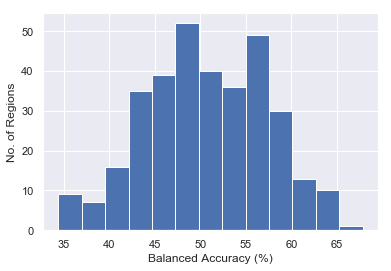

In [13]:
# Plotting the number of regions with balanced accuracies greater than 60%

def showMeROIAccPlot(maxROI, Orig_TS_path_names, tsData, targetCol, boolean):
    ''' This function displays the region accuracy plot and the top 5 regions
    having the highest accuracies
    If 0 is given as an input, this function suppresses any printed messages
    and plots but returns the mean regional accuracy '''

    # Initialise a few variables
    regions = np.zeros([maxROI])
    region_acc = np.zeros([maxROI])
    roiErr = np.zeros([maxROI])

    for n in range(1, maxROI+1):

        tsDataSlice = getROISlice(Orig_TS_path_names, tsData, n)[0]
        tsDataSlice_zscored = tsDataSlice.apply(zscore)

        # Assign the data to variables
        X = tsDataSlice_zscored
        y = np.ravel(targetCol)

        avgScore = get10FoldCVScore(X,y).mean()
        avgSTD = get10FoldCVScore(X,y).std()
        regions[n-1] = n
        region_acc[n-1] = avgScore
        roiErr[n-1] = avgSTD

    df = pd.DataFrame({'Region':regions,'% Accuracy':region_acc,'ROI Error':roiErr})
    df['Region'] = df.Region.astype(int)

    df_sorted = df.sort_values(by='% Accuracy',ascending=False)

    if boolean == 1:
        print(df_sorted[:5].to_string(index=False))
        print('')

        print('Mean Accuracy (across all regions) = ' +
        "{0:.2f}".format(df['% Accuracy'].mean()) + '%')
        print('')

        print('Mean Error (across all regions) = ' +
        "{0:.2f}".format(df['ROI Error'].mean()) + '%')
        print('')

        plt.hist(region_acc, bins='auto')
        plt.xlabel('Balanced Accuracy (%)')
        plt.ylabel('No. of Regions')
        plt.show()
        return
    elif boolean == 0:
        meanROIAcc = '{0:.2f}'.format(df['% Accuracy'].mean())
        AvgROIError = '{0:.2f}'.format(df['ROI Error'].mean())
        return meanROIAcc, AvgROIError

# Call the function to test
showMeROIAccPlot(maxROI, Orig_TS_path_names, tsData, targetCol, 1)

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 2 2 2 2 2 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 1 2 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 2 2 2 1 2 2]

Acc % =  33.3

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 2 1 1 1 1 2 1]

Acc % =  79.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 1 2 2 1 1 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [2 1 2 1 1 2 2 1 1 2]

Acc % =  70.8

Train: [0,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 1 1 1 2 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 2 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 1 1 1 1 1 1 2 1]

Acc % =  54.2

Train: [0,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 1 2 1 1 1 2 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 2 1 2 1 1 2]

Acc % =  37.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [23, 26, 32, 33, 34, 35, 36, 37, 38, 39]

y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 1 1 1 2 1 2 2 2 1]

Acc % =  16.7

Train: [0,

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 2 2 2 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 2 2 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 2 1 1 1 2 1 1 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 2 2 1]

Acc % =  33.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 1 2 2 1 2 2 1 2]

Acc % =  41.7

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 2 1 1 2 1 2 1]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 2 1 2 1 1 2]

Acc % =  50.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 2 1 1 2 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 2 1 1 1 2 2 1 2 2]

Acc % =  41.7

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 2 1 2 1 1 1 1 2 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 2 1 1 1 1]

Acc % =  66.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 2 1 1 1 1]

Acc % =  40.0

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 1 2 1 1 2]

Acc % =  45.8

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 1 2 2 1 1 2 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [56, 58, 59, 63, 64, 65, 67, 68]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 1 2 1 2 1 1]

Acc % =  46.7

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 2 1 1]

Acc % =  40.0

Train: [0, 1, 2, 3, 4, 5, 6, 7


y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [1 1 1 1 1 2 2 1]

Acc % =  30.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [1 1 1 2 2 2 1 1]

Acc % =  73.3

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 2 1 2 1]

Acc % =  45.8

Train: [0, 1, 2, 3, 7, 8, 


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 1 1 1 1 1 1 1]

Acc % =  50.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 2 1 2 2 2]

Acc % =  53.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82]

Validation: [81, 83, 84, 85, 86, 87, 88, 89]

y_test =  [2 1 1 1 2 2 1 1]

y_pred =  [2 1 1 2 1 1 1 1]

Acc % =  56.7

Train: [4, 5, 6, 13, 14, 15, 16, 1

Train: [4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 1 1 1 2 1 2 2]

Acc % =  50.0

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 2 1 1 1 2 1 1 1]

Acc % =  54.2

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33


y_test =  [2 2 1 1 1 2 1 1 1 2]

y_pred =  [1 2 2 2 1 2 1 1 1 2]

Acc % =  70.8

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [40, 41, 42, 43, 44, 45, 46, 47, 49]

y_test =  [1 1 1 1 1 2 2 2 1]

y_pred =  [1 2 1 2 1 2 1 2 2]

Acc % =  58.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [48, 50, 51, 52, 53, 54, 55, 57, 62]

y_test =  [2 1 1 2 1 2 1 1 1]

y_pred =  [1 1 2 1 1 2 1 1 1]

Acc % =  58.3

Train: [0, 1, 2, 3


y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [1 2 2 1 1 2 1 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [60, 61, 66, 69, 70, 72, 73, 74]

y_test =  [2 2 2 1 1 1 1 1]

y_pred =  [2 2 2 2 1 1 1 2]

Acc % =  80.0

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 81, 83, 84, 85, 86, 87, 88, 89]

Validation: [71, 75, 76, 77, 78, 79, 80, 82]

y_test =  [2 1 1 2 2 1 1 1]

y_pred =  [2 1 1 1 2 1 2 1]

Acc % =  73.3

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8,


y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [2 1 2 2 2 1 2 1 1 1]

Acc % =  70.8

Train: [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [4, 5, 6, 13, 15, 16, 20, 21, 22, 24]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 2 1 2 1 2 2 1]

Acc % =  37.5

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Validation: [14, 17, 18, 19, 25, 27, 28, 29, 30, 31]

y_test =  [2 2 2 2 1 1 1 1 1 1]

y_pred =  [1 1 1 1 2 1 2 1 1 1]

Acc % =  33.3

Train: [0,

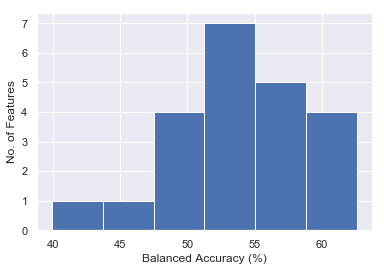

In [14]:
# Plot feature accuracies

def showMeFeatAccPlot(featMat3D, targetCol, boolean):
    ''' This function displays the feature accuracy plot and the top 5 features
    having the highest accuracies
    If 0 is given as an input, this function suppresses any printed messages
    and plots but returns the mean feature accuracy '''

    # Initialise a few variables
    feats = np.zeros(22)
    feat_acc = np.zeros(22)
    featErr = np.zeros([22])

    for n in range(1, 23):

        tsDataSlice = pd.DataFrame(getFeatSlice(featMat3D, n))
        tsDataSlice_zscored = tsDataSlice.apply(zscore)

        # Assign the data to variables
        X = tsDataSlice_zscored
        y = np.ravel(targetCol)

        avgScore = get10FoldCVScore(X,y).mean()
        avgSTD = get10FoldCVScore(X,y).std()
        feats[n-1] = n
        feat_acc[n-1] = avgScore
        featErr[n-1] = avgSTD

    df = pd.DataFrame({'Feature':feats,'% Accuracy':feat_acc,'Feat Error':featErr})
    df['Feature'] = df.Feature.astype(int)

    df_sorted = df.sort_values(by='% Accuracy',ascending=False)

    if boolean == 1:
        print(df_sorted[:5].to_string(index=False))
        print('')

        print('Mean Accuracy (across all features) = ' +
        "{0:.2f}".format(df['% Accuracy'].mean()) + '%')
        print('')

        print('Mean Error (across all features) = ' +
        "{0:.2f}".format(df['Feat Error'].mean()) + '%')
        print('')

        plt.hist(feat_acc, bins='auto')
        plt.xlabel('Balanced Accuracy (%)')
        plt.ylabel('No. of Features')
        plt.show()
        return
    elif boolean == 0:
        meanFeatAcc = '{0:.2f}'.format(df['% Accuracy'].mean())
        AvgFeatError = '{0:.2f}'.format(df['Feat Error'].mean())
        return meanFeatAcc, AvgFeatError

# Call the function to test
showMeFeatAccPlot(featMat3D, targetCol, 1)

      fd   SCZ  Control  Total  SCZ:Control  AvgROIAcc  AvgROIError  \
0   0.72  67.0     73.0  140.0         0.92      49.99        11.56   
1   0.69  67.0     73.0  140.0         0.92      49.99        11.56   
2   0.66  67.0     73.0  140.0         0.92      49.99        11.56   
3   0.63  66.0     72.0  138.0         0.92      50.16        11.68   
4   0.60  64.0     72.0  136.0         0.89      50.18        11.77   
5   0.57  61.0     72.0  133.0         0.85      50.10        11.89   
6   0.54  58.0     70.0  128.0         0.83      50.33        12.28   
7   0.51  55.0     70.0  125.0         0.79      50.14        12.25   
8   0.48  55.0     69.0  124.0         0.80      50.01        12.30   
9   0.45  54.0     69.0  123.0         0.78      49.72        12.51   
10  0.42  50.0     67.0  117.0         0.75      49.91        12.69   
11  0.39  44.0     64.0  108.0         0.69      50.16        12.82   
12  0.36  41.0     60.0  101.0         0.68      50.50        13.38   
13  0.

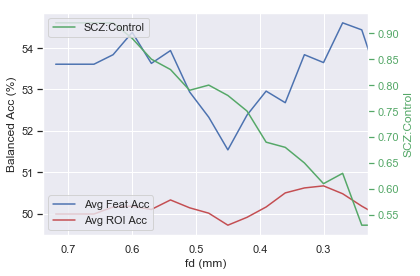

In [15]:
# Plot the fd vs balanced accuracy

# Import and store the fdArray
filePath = '/Users/AV/Desktop/FeatureMatrixData/fdArray_COBRE.txt'
fdArray = pd.read_csv(filePath);

print(fdArray)

fig, ax1 = plt.subplots()

AvgROIError = fdArray.iloc[:,6]
AvgFeatError = fdArray.iloc[:,8]

fd = fdArray.iloc[:,0]
SCZ2Control = fdArray.iloc[:,4]
AvgROIAcc = fdArray.iloc[:,5]
AvgFeatAcc = fdArray.iloc[:,7]

ax1.plot(fd, AvgFeatAcc,'b-')
# ax1.errorbar(fd, AvgFeatAcc, yerr=AvgFeatError, fmt='-o', capsize=5)

ax1.plot(fd, AvgROIAcc, 'r-')
# ax1.errorbar(fd, AvgROIAcc, yerr=AvgROIError, fmt='-o', capsize=5)

plt.xlim(max(fd)+0.02, min(fd)+0.02)
ax1.set_xlabel('fd (mm)')
ax1.set_ylabel('Balanced Acc (%)')

ax2 = ax1.twinx()
ax2.plot(fd, SCZ2Control,'g-')
ax2.set_ylabel('SCZ:Control', color='g')
ax2.tick_params('y', colors='g')
plt.grid(b=None)

ax1.legend(['Avg Feat Acc','Avg ROI Acc'],loc=3)
ax2.legend(['SCZ:Control'],loc=2)
fig.tight_layout()
plt.show()

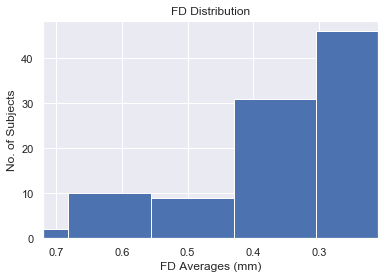

In [16]:
# fd variation across subjects

filePath = '/Users/AV/Dropbox/COBRE/movementData/fdAvgs_COBRE.txt'
fdAvgs = pd.read_csv(filePath,header=None, names=['FD Avgs']);

fdAvgs.hist(column='FD Avgs')

plt.xlim(max(fd), min(fd))
plt.title('FD Distribution')
plt.xlabel('FD Averages (mm)')
plt.ylabel('No. of Subjects')
plt.show()

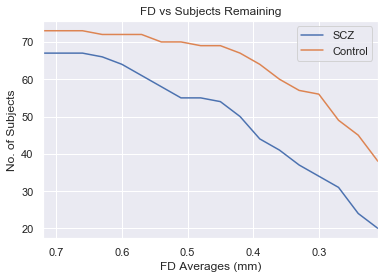

In [17]:
# No. of subjects left as fd decreases

SCZ = fdArray.iloc[:,1]
Control = fdArray.iloc[:,2]

fdArray.plot.line(x='fd', y=['SCZ', 'Control'])

plt.xlim(max(fd), min(fd))
plt.title('FD vs Subjects Remaining')
plt.xlabel('FD Averages (mm)')
plt.ylabel('No. of Subjects')
plt.show()

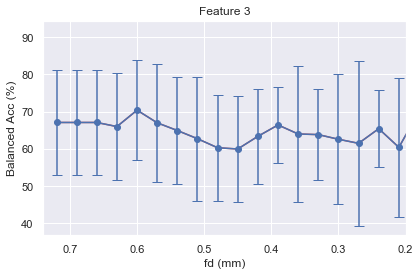

In [19]:
# Plot feat3BalancedAcc as it varies with fd

# Import and store the fdArray
filePath = '/Users/AV/Desktop/FeatureMatrixData/feat3BalancedAcc_COBRE.txt'
df = pd.read_csv(filePath);

# print(df)

fig, ax1 = plt.subplots()

fd = df.iloc[:,0]
feat3Balanced = df.iloc[:,1]
stdDev = df.iloc[:,2]

ax1.plot(fd, feat3Balanced, 'r-')
ax1.errorbar(fd, feat3Balanced, yerr=stdDev, fmt='-o', capsize=5)

plt.title('Feature 3')
plt.xlim(max(fd)+0.02, min(fd)+0.02)
ax1.set_xlabel('fd (mm)')
ax1.set_ylabel('Balanced Acc (%)')

fig.tight_layout()
plt.show()

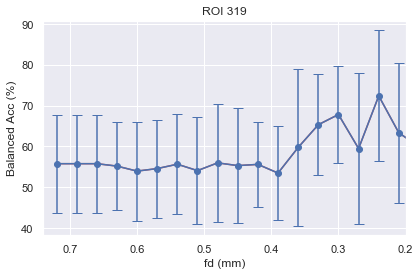

In [21]:
# Plot ROI_BalancedAcc as it varies with fd

# Import and store the fdArray
filePath = '/Users/AV/Desktop/FeatureMatrixData/ROI_BalancedAcc_COBRE.txt'
df = pd.read_csv(filePath);

# print(df)

fig, ax1 = plt.subplots()

fd = df.iloc[:,0]
ROI_Balanced = df.iloc[:,1]
stdDev = df.iloc[:,2]

ax1.plot(fd, ROI_Balanced, 'r-')
ax1.errorbar(fd, ROI_Balanced, yerr=stdDev, fmt='-o', capsize=5)

plt.title('ROI 319')
plt.xlim(max(fd)+0.02, min(fd)+0.02)
ax1.set_xlabel('fd (mm)')
ax1.set_ylabel('Balanced Acc (%)')

fig.tight_layout()
plt.show()